В этом практическом задании мы продолжим работать с кейсом и датасетом из практического задания предыдущего урока по статистическим критериям.

Вспомним сам кейс и полученные выводы.

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import bootstrap

In [2]:
df = pd.read_csv("bootstrap_homework.csv")
df.head()

,passport_id,region,revenue,group
0,135342321,Новосибирск,320,0
1,142791180,Новосибирск,2173,1
2,123514803,Новосибирск,215,0
3,124568474,Новосибирск,1720,0
4,141887661,Новосибирск,645,0


**Выводы из прошлого практического задания**

Мы провели анализ теста с помощью стат. критериев, но у нас осталось много вопросов к результатам теста. Выборки явно недостаточно, чтобы детектить ожидаемые 5% отклонения в средней. При этом пользователи точно отреагировали на изменение цен. Характер распределения изменился. Кажется, что мы должны дать более явный ответ, у кого поменялся ARPPU и в какую сторону. Тут нам поможет универсальный оценщик — бутстрап и проверка гипотез по квантилям распределений между группами.

**Т.е. как и в реальной работе аналитика, нам нужно копнуть немного глубже**

В этом практическом задании мы проверим и найдем ответ на вопрос, как изменилось поведение пользователей после изменения ценовой политики в Новосибирске. Это поможет нам лучше настраивать цены в дальнейшем и повысить выручку. Например, мы можем работать с сегментацией цен. Мы же в команде монетизации!

### Задание 1. Изучение распределений в группах(1/4)
Для начала давайте просто взглянем на квантили распределения в обеих группах.

Найдите 0.7 квантиль распределения revenue для группы 0.

Введите ответ в поле ниже в формате целого числа.

In [4]:
df[df["group"] == 0]["revenue"].quantile(0.7)

960.0

### Задание 1. Изучение распределений в группах (2/4)
Найдите 0.7 квантиль распределения revenue для группы 1.

Введите ответ в поле ниже в формате целого числа.

In [5]:
df[df["group"] == 1]["revenue"].quantile(0.7)

1128.0

### Задание 1. Изучение распределений в группах (3/4)
Также полезно посмотреть, изменились ли меры разброса. Давайте посмотрим межквартильный размах. Межквартильный размах — разница между 1-ым квартилем (0.25) и 3-им квартилем (0.75) распределения.

Найдите межквартильный размах для группы 0.

Введите ответ в поле ниже в формате целого числа.

In [6]:
df[df["group"] == 0]["revenue"].quantile(0.75) - df[df["group"] == 0][
    "revenue"
].quantile(0.25)

963.0

### Задание 1. Изучение распределений в группах (4/4)
Найдите межквартильный размах для группы 1.

Введите ответ в поле ниже в формате целого числа.

In [7]:
df[df["group"] == 1]["revenue"].quantile(0.75) - df[df["group"] == 1][
    "revenue"
].quantile(0.25)

1186.0

### Задание 2. Проверка гипотезы бутстрапом (1/5)
Для начала давайте проверим с помощью бутстрапа один квантиль распределения.

С помощью бутстрапа проверьте гипотезу о равенстве 0.8 квантиля распределений между двумя группами. Альфа = 0.05. Перед стартом первой итерации бутстрапа установите `np.random.seed(1)`. Кол-во итераций бутстрапа = 10000. Отклоняется ли гипотеза H0 о равенстве квантилей распределения?

In [9]:
# функция, возвращающая resample выборок resample_num раз
def get_resampled_data(sample, sample_size, resample_num):
    resampled_data = np.random.choice(
        sample, size=(resample_num, sample_size), replace=True
    )
    return resampled_data


# функция, которая из полученных выборок достает заданную статистику
def get_resampled_stats(resampled_data, stat):
    resampled_stats = stat(resampled_data, axis=1)
    return resampled_stats


# функция, которая достает квантили из resample выборок
def get_resampled_quantile(resampled_data, q=0.5):
    resampled_stats = np.quantile(resampled_data, q=q, axis=1)
    return resampled_stats


def bootstrap_ab_test(
    sample_data_A, sample_data_B, stat, resample_num, alpha, q
):
    """
    sample_data_A - значения в выборке А
    sample_data_B - значения в выборке B
    stat - можно передать оцениваемую функцию
    resample_num - количество итераций извлечения resample выборок в бутстрапе
    alpha - уровень значимости при проверке
    q - указывается если вы оцениваете определенный квантиль распределения

    """
    # получаем бутстрапированные данные
    resampled_data_A = get_resampled_data(
        sample_data_A, len(sample_data_A), resample_num
    )
    resampled_data_B = get_resampled_data(
        sample_data_B, len(sample_data_B), resample_num
    )

    if q is not None:
        resampled_stats_A = get_resampled_quantile(resampled_data_A, q)
        resampled_stats_B = get_resampled_quantile(resampled_data_B, q)
    else:
        resampled_stats_A = get_resampled_stats(resampled_data_A, stat)
        resampled_stats_B = get_resampled_stats(resampled_data_B, stat)

    # рассчитываем разницу для статистики
    resampled_diffs = resampled_stats_B - resampled_stats_A

    # рассчитываем перцентильный бутстрап
    perc_ci = np.quantile(resampled_diffs, [alpha / 2, 1 - alpha / 2])

    if q is not None:
        samples_diff = np.quantile(sample_data_B, q) - np.quantile(
            sample_data_A, q
        )
    else:
        samples_diff = stat(sample_data_B) - stat(sample_data_A)

    # рассчитываем p-value
    adjusted_resampled_diffs = resampled_diffs - samples_diff
    false_positive_count = np.sum(
        np.abs(adjusted_resampled_diffs) >= np.abs(samples_diff)
    )
    p_value = false_positive_count / resample_num

    # формируем результат
    boot_data_object = {
        "resample_stats_A": resampled_stats_A,
        "resample_stats_B": resampled_stats_B,
        "resampled_diffs": resampled_diffs,
        "conf_int": perc_ci,
        "stat_diffs_std": resampled_diffs.std(),
        "p_value": p_value,
    }
    return boot_data_object


# также сделаем функцию, отрисовывающую результат проверки гипотез через бутстрап
def boot_data_plot(boot_data_object, alpha):
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    axes[0].set_title("A & B botstraped stats distribution")
    sns.kdeplot(
        ax=axes[0],
        data=boot_data_object["resample_stats_A"],
        label="resample_stats_A",
        color="blue",
    )
    axes[0].axvline(
        x=boot_data_object["resample_stats_A"].mean(),
        linestyle="--",
        color="blue",
    )
    sns.kdeplot(
        ax=axes[0],
        data=boot_data_object["resample_stats_B"],
        label="resample_stats_B",
        color="red",
    )
    axes[0].axvline(
        x=boot_data_object["resample_stats_B"].mean(),
        linestyle="--",
        color="red",
    )
    axes[0].legend(loc="upper right")

    axes[1].set_title("A & B botstraped stats diffs distribution")
    sns.kdeplot(
        ax=axes[1],
        data=boot_data_object["resampled_diffs"],
        label="resample_stats_diffs",
        color="black",
    )
    axes[1].axvline(x=0, color="red")
    axes[1].axvline(
        x=boot_data_object["resampled_diffs"].mean(),
        linestyle="--",
        color="black",
    )
    axes[1].vlines(
        boot_data_object["conf_int"],
        ymin=0,
        ymax=0.05,
        linestyle="-",
        color="black",
    )
    axes[1].legend(loc="upper right")

    # сделаем часть, которая принтует основные значения и вывод по проверке гипотез
    if boot_data_object["p_value"] < alpha:
        conclusion = "H0 rejected!!!"
    else:
        conclusion = "H0 doesn't rejected!!!"

    print(conclusion)
    print("A sample stat mean =", boot_data_object["resample_stats_A"].mean())
    print("B sample stat mean =", boot_data_object["resample_stats_B"].mean())
    print("Avg lift =", boot_data_object["resampled_diffs"].mean())
    print("p-val =", boot_data_object["p_value"])
    print("Diffs ci:", boot_data_object["conf_int"])
    print("stats diffs std = ", boot_data_object["stat_diffs_std"])


H0 doesn't rejected!!!
A sample stat mean = 1728.6373800000008
B sample stat mean = 1770.6809
Avg lift = 42.04351999999918
p-val = 0.1804
Diffs ci: [-15. 120.]
stats diffs std =  32.94911825845397


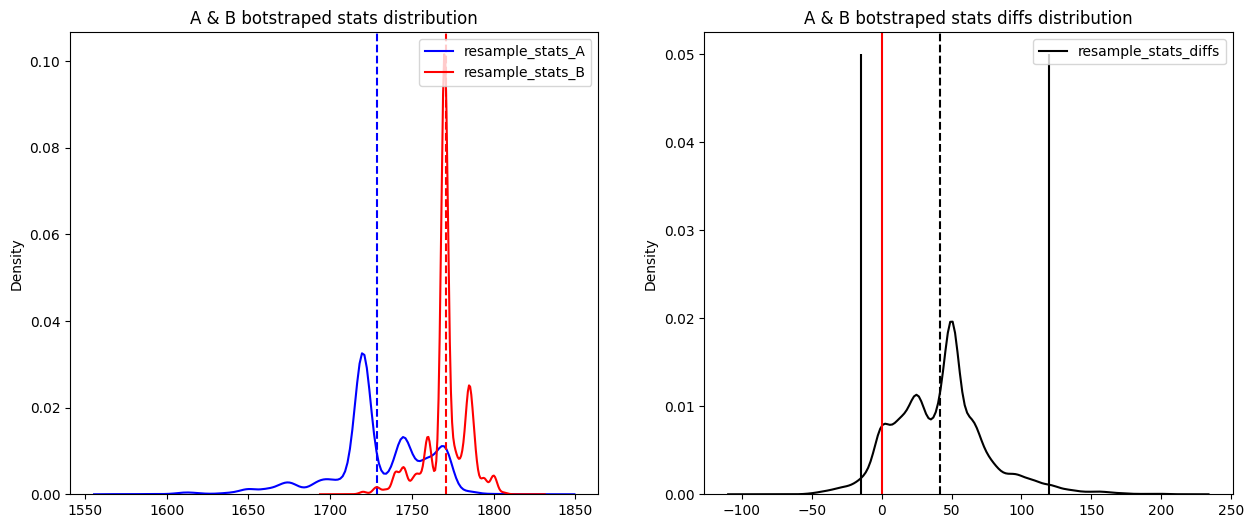

In [11]:
np.random.seed(1)

boot_data = bootstrap_ab_test(
    sample_data_A=df[df["group"] == 0]["revenue"],
    sample_data_B=df[df["group"] == 1]["revenue"],
    stat=None,
    resample_num=10000,
    alpha=0.05,
    q=0.8,
)

boot_data_plot(boot_data, alpha=0.05)

In [12]:
print("Отклоняется ли гипотеза H0? ->", boot_data["p_value"] < 0.05)

Отклоняется ли гипотеза H0? -> False


### Задание 2. Проверка гипотезы бутстрапом (2/5)
Укажите полученное с помощью бутстрапа p_value.

Введите ответ в поле ниже с точностью до четырех знаков в десятичной части. Используйте точку для разделения целой и дробной части.



In [13]:
boot_data["p_value"]

0.1804

### Задание 2. Проверка гипотезы бутстрапом (3/5)

С помощью бутстрапа проверьте гипотезу о равенстве 0.4 квантиля распределениий между двумя группами. Альфа = 0.05. Перед стартом первой иттерации бутстрапа установите `np.random.seed(1)`. Кол-во итераций бутстрапа = 10000. Отклоняется ли гипотеза H0 о равенстве квантилей распределения?

H0 rejected!!!
A sample stat mean = 425.79158000000007
B sample stat mean = 369.6802
Avg lift = -56.111380000000075
p-val = 0.0
Diffs ci: [-79. -23.]
stats diffs std =  14.428148824280914


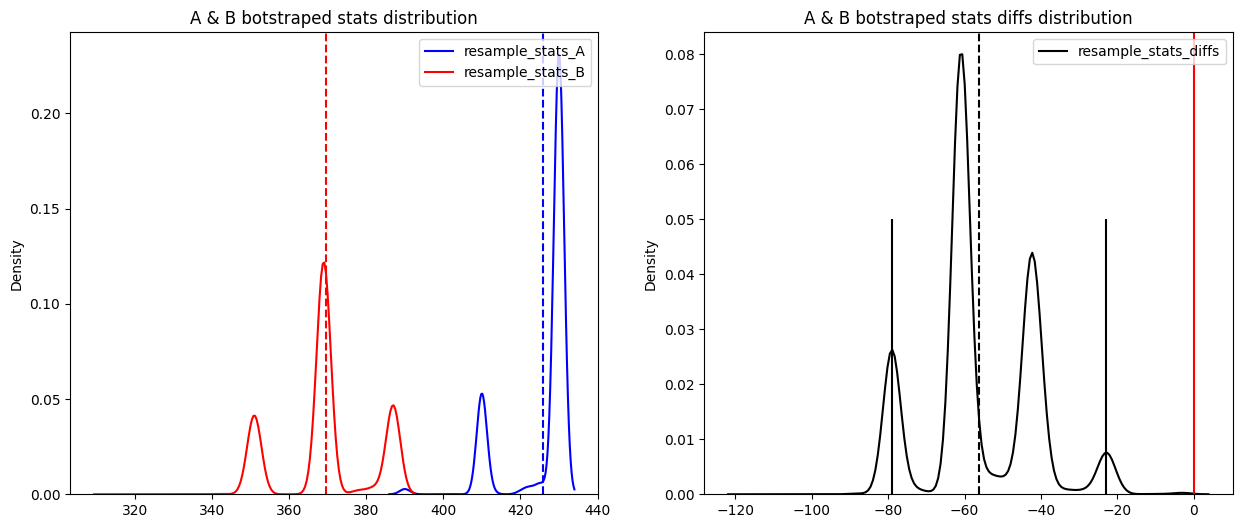

In [14]:
np.random.seed(1)

boot_data = bootstrap_ab_test(
    sample_data_A=df[df["group"] == 0]["revenue"],
    sample_data_B=df[df["group"] == 1]["revenue"],
    stat=None,
    resample_num=10000,
    alpha=0.05,
    q=0.4,
)

boot_data_plot(boot_data, alpha=0.05)

In [15]:
print("Отклоняется ли гипотеза H0? ->", boot_data["p_value"] < 0.05)

Отклоняется ли гипотеза H0? -> True


### Задание 2. Проверка гипотезы бутстрапом (4/5)
Укажите среднее разниц квантилей, полученное с помощью бутстрапа на предыдущем степе.

Введите ответ в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

In [18]:
round(np.mean(boot_data["resampled_diffs"]), 1)

-56.1

### Задание 2. Проверка гипотезы бутстрапом (5/5)
С помощью бутстрапа проверьте гипотезу о равенстве 0.65 квантиля распределений между двумя группами. Альфа = 0.05. Перед стартом первой итерации бутстрапа установите `np.random.seed(1)`. Кол-во итераций бутстрапа = 10000. Укажите p-value, полученное в этой проверке.

Введите ответ в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

H0 rejected!!!
A sample stat mean = 859.3013450000001
B sample stat mean = 1006.4388
Avg lift = 147.137455
p-val = 0.0
Diffs ci: [100. 172.]
stats diffs std =  22.08184830065125


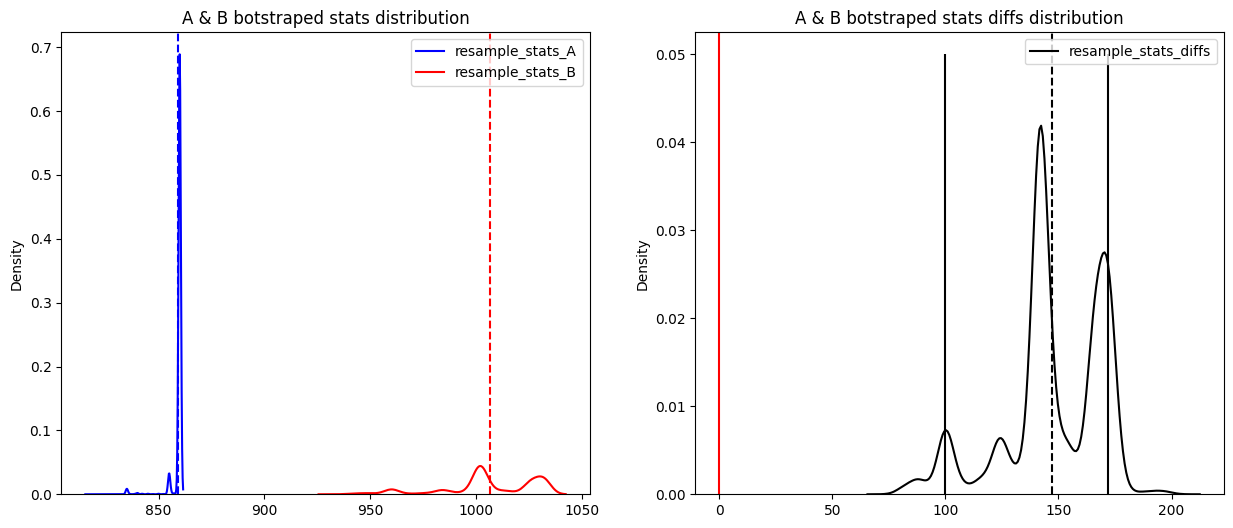

In [19]:
np.random.seed(1)

boot_data = bootstrap_ab_test(
    sample_data_A=df[df["group"] == 0]["revenue"],
    sample_data_B=df[df["group"] == 1]["revenue"],
    stat=None,
    resample_num=10000,
    alpha=0.05,
    q=0.65,
)

boot_data_plot(boot_data, alpha=0.05)

In [20]:
boot_data["p_value"]

0.0

### Задание 3. Децильный анализ (1/4)
Разовые проверки квантилей распределения показывают, что эффекты неоднородные, влияние на выборку 1 после изменения цен явно имело фрагментарный и неодинаковый характер. Давайте проведем децильный анализ, т.е. поищем эффекты во всем пространстве децилей распределения.

Определите с помощью бутстрапа, с какого перцентиля распределения начинает детектится эффект на revenue.

- Стартуем симуляции с 0.01 перцентиля.
- Шаг перебора перцентилей в симуляциях 0.01
- Перед стартом перебора установите `np.random.seed(1)`

Для каждой итерации перебора используйте следующую конфигурацию бутстрапа:

- альфа = 0.05
- кол-во итераций внутри бутстрапа = 2000
- поправка на множественные сравнения - Бонферонни. Подобно примеру в уроке, нужно делить альфа на кол-во гипотез (перцентилей в переборе)

Введите ответ в поле ниже с точностью до двух знаков в десятичной части. Используйте точку для разделения целой и дробной части.

  0%|          | 0/99 [00:00<?, ?it/s]

Target percentile =  0.01


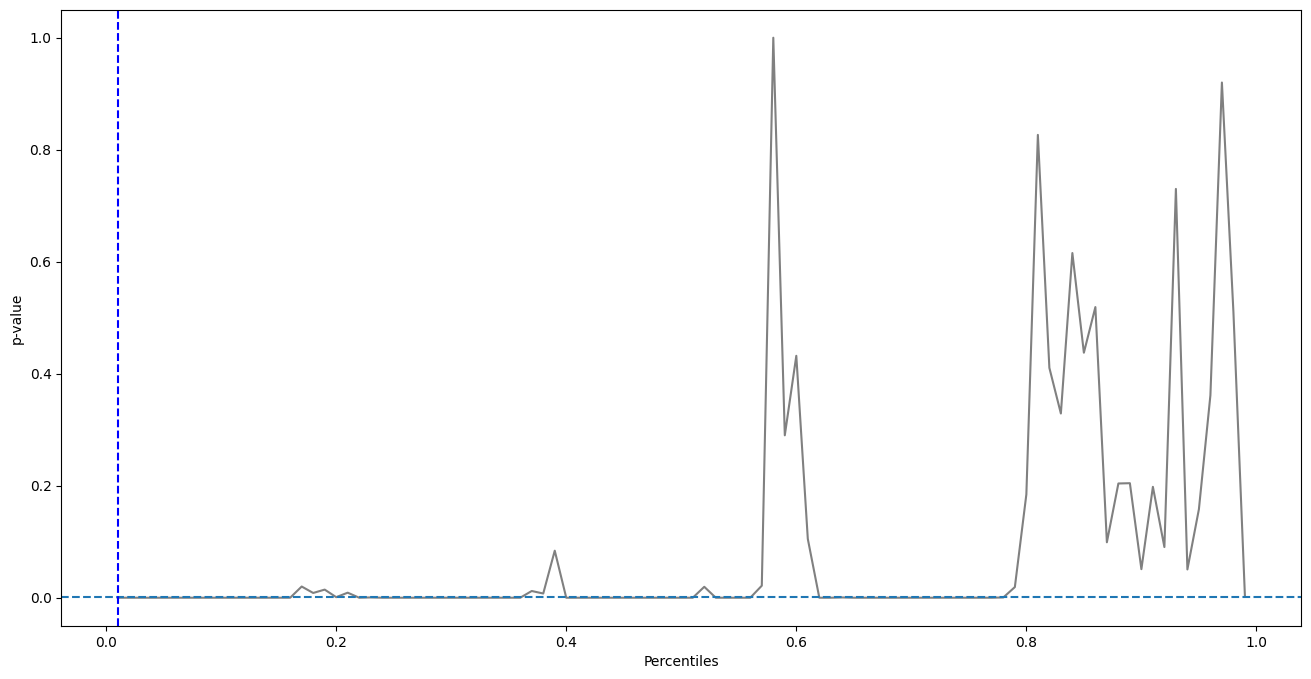

In [29]:
perc_linspace = np.arange(
    start=0.01, stop=1, step=0.01
)  # создаем массив квантиле по которым мы будем проверять гипотезу о равенстве квантиля

p_val_list = []
diffs_list = []
lower_ci_list = []
upper_ci_list = []

# для каждого определяемого квантиля проверяем гипотезу о равенстве квантилей с помощью бутстрапа
np.random.seed(1)
for i in tqdm(perc_linspace):
    boot_data = bootstrap_ab_test(
        df[df["group"] == 0]["revenue"],
        sample_data_B=df[df["group"] == 1]["revenue"],
        stat=np.mean,
        resample_num=2000,
        alpha=(0.05 / len(perc_linspace)),
        q=i,
    )  # не забываем штрафовать нашу альфа. Пока используем самый простой и страшный Бонферрони
    p_val_list.append(boot_data["p_value"])
    diffs_list.append(boot_data["resampled_diffs"].mean())
    lower_ci_list.append(boot_data["conf_int"][0])
    upper_ci_list.append(boot_data["conf_int"][1])
p_val_list = np.array(p_val_list)
diffs_list = np.array(diffs_list)
lower_ci_list = np.array(lower_ci_list)
upper_ci_list = np.array(upper_ci_list)

plt.figure(figsize=(16, 8))
sns.lineplot(x=np.round(perc_linspace, 2), y=p_val_list, color="gray")
plt.xlabel("Percentiles")
plt.ylabel("p-value")
plt.axhline(y=(0.05 / len(perc_linspace)), linestyle="--")
target_percentile = perc_linspace[
    p_val_list <= (0.05 / len(perc_linspace))
].min()
plt.axvline(target_percentile, linestyle="--", color="blue")
print(
    "Target percentile = ",
    perc_linspace[p_val_list <= (0.05 / len(perc_linspace))].min(),
)


Text(0, 0.5, 'Diffs and 95% CI with Bonferoni corr.')

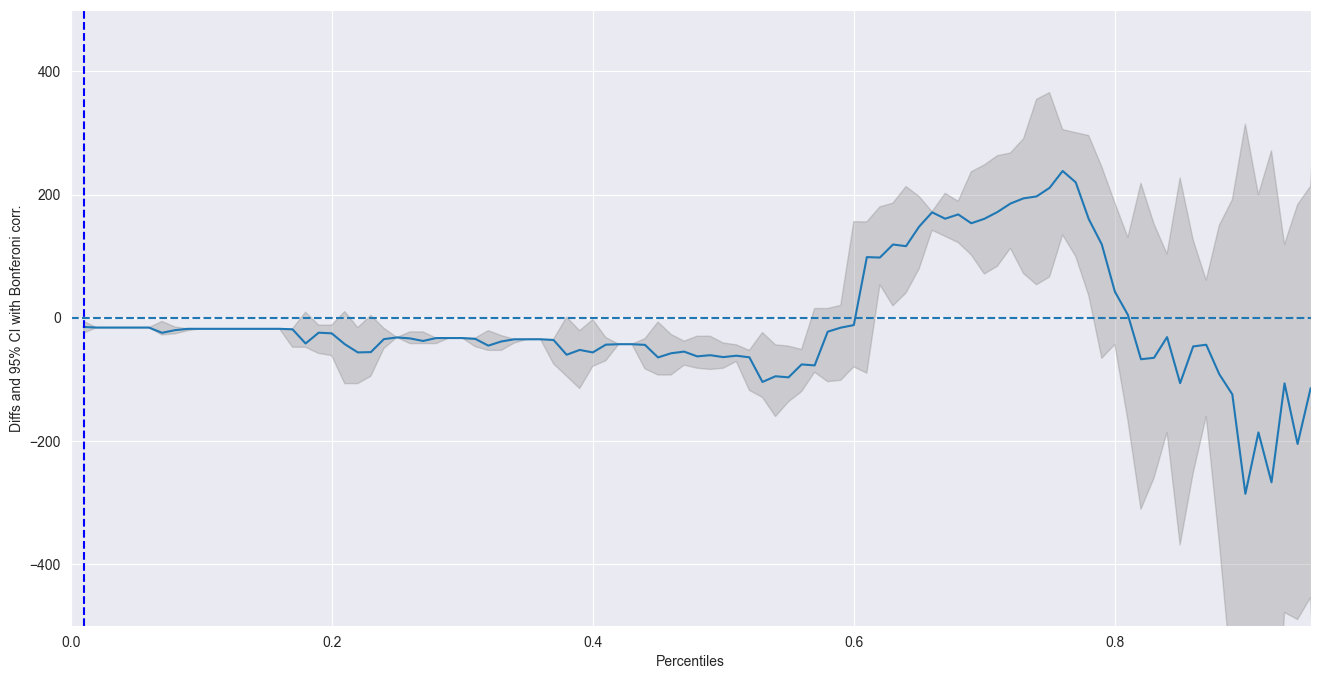

In [30]:
plt.figure(figsize=(16, 8))
sns.set_style("darkgrid")
plt.ylim(-500, 500)
plt.xlim(0, 0.95)
sns.lineplot(x=perc_linspace, y=diffs_list, err_style="band")
plt.axhline(y=0, linestyle="--")
plt.axvline(target_percentile, linestyle="--", color="blue")
plt.fill_between(
    perc_linspace, lower_ci_list, upper_ci_list, color="grey", alpha=0.3
)
plt.xlabel("Percentiles")
plt.ylabel("Diffs and 95% CI with Bonferoni corr.")

In [31]:
print(
    "Мы начинаем ловить эффект с {} перцентиля".format(
        round(target_percentile, 2)
    )
)

Мы начинаем ловить эффект с 0.01 перцентиля


### Задание 3. Децильный анализ (2/4)
Какой абсолютный наблюдаемый эффект находит при проверке бутстрапом на этом квантиле из симуляции проведенной выше?

Нужно указать среднюю разницу между квантилями по всем иттерациям бутстрапа. Введите ответ в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

In [32]:
print(
    "Средняя разница для найденного квантиля составила =",
    round(diffs_list[perc_linspace == target_percentile][0], 1),
)

Средняя разница для найденного квантиля составила = -15.0


### Задание 3. Децильный анализ(3/4)
С какого перцентиля мы первый раз начинаем ловить положительный эффект между квантилями (квантиль группа 1 > квантиля группы 0)

Введите ответ в поле ниже с точностью до двух знаков в десятичной части. Используйте точку для разделения целой и дробной части.

In [ ]:
valued_perc = perc_linspace[p_val_list <= (0.05 / len(perc_linspace))]
valued_diffs = diffs_list[p_val_list <= (0.05 / len(perc_linspace))]
target_positive_perc = valued_perc[np.argmax(valued_diffs > 0)]

print(
    "При проверке бустрапом, мы первый раз начинаем ловить положительный эффект между квантилями с {} квантиля".format(
        target_positive_perc
    )
)

При проверке бустрапом, мы первый раз начинаем ловить положительный эффект между квантилями с 0.62 квантиля


### Задание 3. Децильный анализ (4/4)
Какой абсолютный наблюдаемый эффект находится при проверке бутстрапом на квантиле из симуляции, проведенной в предыдущем задании?

Нужно указать среднюю разницу между квантилями по всем итерациям бутстрапа. Введите ответ в поле ниже с точностью до одного знака в десятичной части. Используйте точку для разделения целой и дробной части.

In [52]:
print(
    "Средняя разница для найденного квантиля составила =",
    round(diffs_list[perc_linspace == 0.62][0], 1),
)

Средняя разница для найденного квантиля составила = 97.7


### Резюме
Как мы видим бутстрап помогает тестировать более сложные гипотезы, например о квантилях распределения. С его помощью мы может производить поиск по всем децилям распределения. В конкретном кейсе это помогло найти области в которых цена отработала в сторону снижения ARPPU, и что более важно области в которых изменение цен увеличило ARPPU.

Скорее всего после этого анализа менеджер захочет менять цены сегментационно, а не всем сразу. Это позволит расти по выручке за счет тех, у кого менее эластичная реакция на рост цен, и не трогать более эластичный спрос.